In [55]:
# upload data
# libraries extraction
import glob 
import os 
import pandas as pd
import numpy as np 
from scipy.stats import ttest_ind 
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt 

In [56]:

df = pd.read_csv('C:/Users/Betty Reinhardova/Desktop/University/Thesis - Ms/data/data_thesis.csv')
df.head(3)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,...,revt,sale,seq,wcap,xrd,costat,mkvalt,gsector,sic,state
0,1004,31/05/2013,2012,INDL,C,D,STD,AIR,AAR CORP,USD,...,2167.1,2167.1,918.6,644.7,NaN,A,790.0029,20.0,5080,IL
1,1004,31/05/2014,2013,INDL,C,D,STD,AIR,AAR CORP,USD,...,2035.0,2035.0,999.5,714.8,NaN,A,961.3080,20.0,5080,IL
2,1004,31/05/2015,2014,INDL,C,D,STD,AIR,AAR CORP,USD,...,1594.3,1594.3,845.1,542.1,NaN,A,1046.3954,20.0,5080,IL


In [57]:
#creating unique ID
df['id'] = df.index + 1
df.head()
df['id'].count()

56013

In [58]:
#remove rows that do not have tic code
#filter out tic codes that are shorter than 4 or five letters = no special characters...
#remove sic in range of 4900-4999 (including)
#remove sic in range of 6000-6999 (including)
df['tic'] = df['tic'].astype("string")
df.dropna(subset=['tic'], inplace=True) 

df.dropna(subset=['sic'], inplace=True)
print(df['tic'].count())
print(df['tic'].str.len())

#FILTER TIC ONLY 4-5 LETTERS
#print(df.dtypes) 
#print(((df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)).count())
#df.drop(df[(df['tic'].str.len() ==5) | (df['tic'].str.len() ==4)].index, inplace=True)

#print(df['tic'].str.match('[A-z]{4,5}'))

df[(df['tic'].str.match('[A-z]{4,5}'))]

df.drop(df[(df['sic'] >= 4900) & (df['sic'] <= 4999)].index, inplace=True)
df.drop(df[(df['sic'] >= 6000) & (df['sic'] <= 6999)].index, inplace=True)
#df['id'].count()
df.drop(df.columns[[3,4,5,6,10,32]], axis=1, inplace=True)

df.shape[0]

55998
0        3
1        3
2        3
3        3
4        3
        ..
56008    4
56009    4
56010    4
56011    5
56012    5
Name: tic, Length: 55998, dtype: Int64


27815

In [59]:
df['xrd'].fillna(0,inplace=True)
df['at'].fillna(0,inplace=True)
df['wcap'].fillna(0,inplace=True)
df['ebit'].fillna(0,inplace=True)
df['re'].fillna(0,inplace=True)
df['sale'].fillna(0,inplace=True)
df['derac'].fillna(0,inplace=True)
df['deralt'].fillna(0,inplace=True)
df['derlc'].fillna(0,inplace=True)
df['derllt'].fillna(0,inplace=True)
df['cidergl'].fillna(0,inplace=True)
df['lt'].fillna(0,inplace=True)
df.head(30)

,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,revt,sale,seq,wcap,xrd,mkvalt,gsector,sic,state,id
0,1004,31/05/2013,2012,AIR,AAR CORP,USD,2136.900,0.600,0.0,0.0,...,2167.100,2167.100,918.600,644.700,0.0,790.0029,20.0,5080,IL,1
1,1004,31/05/2014,2013,AIR,AAR CORP,USD,2199.500,0.700,0.0,0.1,...,2035.000,2035.000,999.500,714.800,0.0,961.3080,20.0,5080,IL,2
2,1004,31/05/2015,2014,AIR,AAR CORP,USD,1515.000,2.600,0.0,0.0,...,1594.300,1594.300,845.100,542.100,0.0,1046.3954,20.0,5080,IL,3
3,1004,31/05/2016,2015,AIR,AAR CORP,USD,1442.100,0.000,0.0,0.0,...,1662.600,1662.600,865.800,544.100,0.0,842.5112,20.0,5080,IL,4
4,1004,31/05/2017,2016,AIR,AAR CORP,USD,1504.100,0.000,0.0,0.0,...,1767.600,1767.600,914.200,553.400,0.0,1200.3288,20.0,5080,IL,5
5,1004,31/05/2018,2017,AIR,AAR CORP,USD,1524.700,0.000,0.0,0.0,...,1748.300,1748.300,936.300,609.400,0.0,1551.4580,20.0,5080,IL,6
6,1004,31/05/2019,2018,AIR,AAR CORP,USD,1517.200,0.000,0.0,0.0,...,2051.800,2051.800,905.900,595.000,0.0,1046.7709,20.0,5080,IL,7
7,1045,31/12/2013,2013,AAL,AMERICAN AIRLINES GROUP INC,USD,42278.000,52.000,109.0,0.0,...,26712.000,26712.000,-2731.000,517.000,0.0,6591.9923,20.0,4512,TX,8
8,1045,31/12/2014,2014,AAL,AMERICAN AIRLINES GROUP INC,USD,43771.000,-58.000,0.0,0.0,...,42650.000,42650.000,2021.000,-1323.000,0.0,37405.5843,20.0,4512,TX,9
9,1045,31/12/2015,2015,AAL,AMERICAN AIRLINES GROUP INC,USD,48415.000,-9.000,0.0,0.0,...,40990.000,40990.000,5635.000,-3620.000,0.0,26452.7417,20.0,4512,TX,10


In [60]:
df['rd intensity'] = df['xrd'] / df['at']
#create new variable - R&D intensity = R&D expenditure / TA
df['financial distress prob'] = (1.2 * df['wcap'] + 1.4 * df['re'] + 3.3 * df['ebit'] + 0.999 * df['sale'])/df['at']
#create new variable - Altman Z-score = (1.2 x WC + 1.4 x RE + 3.3 x EBIT + 0.999 x Sales)/TA -> score lower than 1.65 = risky business -> please check the range and go back to thesis page 26
df['hedging intensity'] = (df['derac'] + df['deralt'] + df['derlc']) + df['derllt'] / df['at']

df['hedging intensity'].fillna(0,inplace=True)
df['rd intensity'].fillna(0,inplace=True)
df['financial distress prob'].fillna(0,inplace=True)

#df[['rd intensity', 'hedging intensity']].replace(np.nan, 0)


df.head(10)
#df.dtypes


,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,wcap,xrd,mkvalt,gsector,sic,state,id,rd intensity,financial distress prob,hedging intensity
0,1004,31/05/2013,2012,AIR,AAR CORP,USD,2136.9,0.6,0.0,0.0,...,644.7,0.0,790.0029,20.0,5080,IL,1,0.0,1.941463,0.000000
1,1004,31/05/2014,2013,AIR,AAR CORP,USD,2199.5,0.7,0.0,0.1,...,714.8,0.0,961.3080,20.0,5080,IL,2,0.0,1.920748,0.101273
2,1004,31/05/2015,2014,AIR,AAR CORP,USD,1515.0,2.6,0.0,0.0,...,542.1,0.0,1046.3954,20.0,5080,IL,3,0.0,2.020004,0.000000
3,1004,31/05/2016,2015,AIR,AAR CORP,USD,1442.1,0.0,0.0,0.0,...,544.1,0.0,842.5112,20.0,5080,IL,4,0.0,2.374362,0.000000
4,1004,31/05/2017,2016,AIR,AAR CORP,USD,1504.1,0.0,0.0,0.0,...,553.4,0.0,1200.3288,20.0,5080,IL,5,0.0,2.425286,0.000000
5,1004,31/05/2018,2017,AIR,AAR CORP,USD,1524.7,0.0,0.0,0.0,...,609.4,0.0,1551.4580,20.0,5080,IL,6,0.0,2.455114,0.000000
6,1004,31/05/2019,2018,AIR,AAR CORP,USD,1517.2,0.0,0.0,0.0,...,595.0,0.0,1046.7709,20.0,5080,IL,7,0.0,2.679619,0.000000
7,1045,31/12/2013,2013,AAL,AMERICAN AIRLINES GROUP INC,USD,42278.0,52.0,109.0,0.0,...,517.0,0.0,6591.9923,20.0,4512,TX,8,0.0,0.355551,109.000000
8,1045,31/12/2014,2014,AAL,AMERICAN AIRLINES GROUP INC,USD,43771.0,-58.0,0.0,0.0,...,-1323.0,0.0,37405.5843,20.0,4512,TX,9,0.0,0.899939,0.000000
9,1045,31/12/2015,2015,AAL,AMERICAN AIRLINES GROUP INC,USD,48415.0,-9.0,0.0,0.0,...,-3620.0,0.0,26452.7417,20.0,4512,TX,10,0.0,1.080149,0.000000


In [61]:
#df['dummy hedge'] = pd.get_dummies(df['hedging intensity'])
dummy_hedge = df['hedge group'] = (df['hedging intensity'] > 0).astype(int)
#hedger = dummy_hedge==1
#nonhedger = dummy_hedge==0
#hedger = [df['hedge group'] == 1]
#nonhedger = [df['hedge group] == 0]
df.head(10)



,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,xrd,mkvalt,gsector,sic,state,id,rd intensity,financial distress prob,hedging intensity,hedge group
0,1004,31/05/2013,2012,AIR,AAR CORP,USD,2136.9,0.6,0.0,0.0,...,0.0,790.0029,20.0,5080,IL,1,0.0,1.941463,0.000000,0
1,1004,31/05/2014,2013,AIR,AAR CORP,USD,2199.5,0.7,0.0,0.1,...,0.0,961.3080,20.0,5080,IL,2,0.0,1.920748,0.101273,1
2,1004,31/05/2015,2014,AIR,AAR CORP,USD,1515.0,2.6,0.0,0.0,...,0.0,1046.3954,20.0,5080,IL,3,0.0,2.020004,0.000000,0
3,1004,31/05/2016,2015,AIR,AAR CORP,USD,1442.1,0.0,0.0,0.0,...,0.0,842.5112,20.0,5080,IL,4,0.0,2.374362,0.000000,0
4,1004,31/05/2017,2016,AIR,AAR CORP,USD,1504.1,0.0,0.0,0.0,...,0.0,1200.3288,20.0,5080,IL,5,0.0,2.425286,0.000000,0
5,1004,31/05/2018,2017,AIR,AAR CORP,USD,1524.7,0.0,0.0,0.0,...,0.0,1551.4580,20.0,5080,IL,6,0.0,2.455114,0.000000,0
6,1004,31/05/2019,2018,AIR,AAR CORP,USD,1517.2,0.0,0.0,0.0,...,0.0,1046.7709,20.0,5080,IL,7,0.0,2.679619,0.000000,0
7,1045,31/12/2013,2013,AAL,AMERICAN AIRLINES GROUP INC,USD,42278.0,52.0,109.0,0.0,...,0.0,6591.9923,20.0,4512,TX,8,0.0,0.355551,109.000000,1
8,1045,31/12/2014,2014,AAL,AMERICAN AIRLINES GROUP INC,USD,43771.0,-58.0,0.0,0.0,...,0.0,37405.5843,20.0,4512,TX,9,0.0,0.899939,0.000000,0
9,1045,31/12/2015,2015,AAL,AMERICAN AIRLINES GROUP INC,USD,48415.0,-9.0,0.0,0.0,...,0.0,26452.7417,20.0,4512,TX,10,0.0,1.080149,0.000000,0


In [62]:
# CONTROL VARIABLES
df['size'] = np.log(df['at'])
# SIZE = natural log of bv assets
df['fp'] = df['ebitda'] / df['at'] 
# FP = EBITDA / TA
df['ast'] = df['ppent'] / df['at']
#AST = PP&E / TA 
df['mb'] = df['mkvalt']/ (df['at'] - df['lt']) 
# M/B = market value of equity+ book value of debt / TA   CHECK
df['leve'] = df['lt']
# Leve
df['sector'] = df['sic']
# SECTOR = fixed effect
df['time'] = df['fyear']
# TIME
df['defr'] = df['financial distress prob']
# Def R = altman zcosre
df['size'].fillna(0,inplace=True)
df['fp'].fillna(0,inplace=True)
df['ast'].fillna(0,inplace=True)
df['mb'].fillna(0,inplace=True)
df['leve'].fillna(0,inplace=True)
df['defr'].fillna(0,inplace=True)
df.head(10)

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,gvkey,datadate,fyear,tic,conm,curcd,at,cidergl,derac,deralt,...,hedging intensity,hedge group,size,fp,ast,mb,leve,sector,time,defr
0,1004,31/05/2013,2012,AIR,AAR CORP,USD,2136.9,0.6,0.0,0.0,...,0.000000,0,7.667111,0.114746,0.199541,0.859166,1217.4,5080,2012,1.941463
1,1004,31/05/2014,2013,AIR,AAR CORP,USD,2199.5,0.7,0.0,0.1,...,0.101273,1,7.695985,0.116390,0.187906,0.960636,1198.8,5080,2013,1.920748
2,1004,31/05/2015,2014,AIR,AAR CORP,USD,1515.0,2.6,0.0,0.0,...,0.000000,0,7.323171,0.055248,0.194719,1.238191,669.9,5080,2014,2.020004
3,1004,31/05/2016,2015,AIR,AAR CORP,USD,1442.1,0.0,0.0,0.0,...,0.000000,0,7.273856,0.094931,0.217669,0.973101,576.3,5080,2015,2.374362
4,1004,31/05/2017,2016,AIR,AAR CORP,USD,1504.1,0.0,0.0,0.0,...,0.000000,0,7.315950,0.098531,0.240343,1.312983,589.9,5080,2016,2.425286
5,1004,31/05/2018,2017,AIR,AAR CORP,USD,1524.7,0.0,0.0,0.0,...,0.000000,0,7.329553,0.082967,0.207647,1.657010,588.4,5080,2017,2.455114
6,1004,31/05/2019,2018,AIR,AAR CORP,USD,1517.2,0.0,0.0,0.0,...,0.000000,0,7.324622,0.101173,0.229897,1.155504,611.3,5080,2018,2.679619
7,1045,31/12/2013,2013,AAL,AMERICAN AIRLINES GROUP INC,USD,42278.0,52.0,109.0,0.0,...,109.000000,1,10.652022,0.069918,0.455532,-2.413765,45009.0,4512,2013,0.355551
8,1045,31/12/2014,2014,AAL,AMERICAN AIRLINES GROUP INC,USD,43771.0,-58.0,0.0,0.0,...,0.000000,0,10.686727,0.150442,0.527381,18.508453,41750.0,4512,2014,0.899939
9,1045,31/12/2015,2015,AAL,AMERICAN AIRLINES GROUP INC,USD,48415.0,-9.0,0.0,0.0,...,0.000000,0,10.787565,0.183641,0.568212,4.694364,42780.0,4512,2015,1.080149


In [63]:
# descriptive statistics 
from IPython.display import Image
descriptives_stat = np.round(df.describe(include='number'),2).transpose()[['count','mean','std','min','max']]
descriptives_stat.to_csv('descriptives_statistics.csv')
#WHY DOESN'T IT PRINT WHAT I TOLD IT TO DO?
descriptives_stat.to_latex('summary stats.tex')
#Image(width=600, filename='Descriptives Statistics Table (LaTex).png')
descriptives_stat 

,count,mean,std,min,max
gvkey,27815.0,76299.01,75711.14,1004.00,351590.00
fyear,27815.0,2016.06,2.05,2012.00,2019.00
at,27815.0,7217.54,31917.69,0.00,817729.00
cidergl,27815.0,-1.17,134.89,-12579.00,8999.00
derac,27815.0,15.68,191.79,-45.00,14037.00
deralt,27815.0,16.20,175.03,-22.21,6654.34
derhedgl,8455.0,-2.61,124.41,-4480.42,2561.78
derlc,27815.0,17.78,229.73,-24.07,13507.35
derllt,27815.0,16.61,178.23,-8.66,9154.05
dlc,26611.0,393.92,2971.67,0.00,119331.00


In [64]:
df['rd intensity'].isnull().sum()
df['mb'].isnull().sum()
df['fp'].isnull().sum()
df['financial distress prob'].isnull().sum()
df['financial distress prob'].dtypes

dtype('float64')

C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_6216\3498530925.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sic_codes, rotation=0)


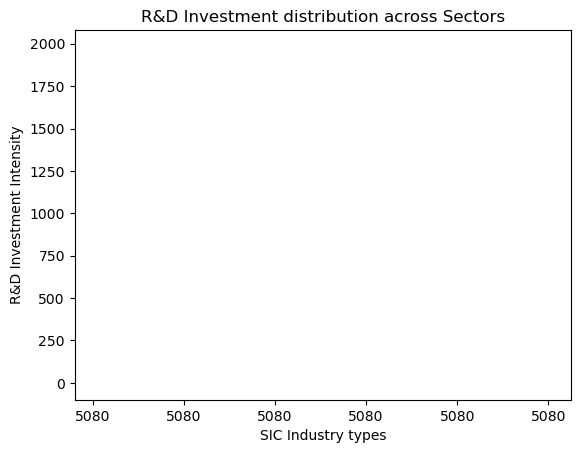

In [65]:
sic_codes = df['sic']
rd_investment = df['rd intensity']

# Create a bar chart
fig, ax = plt.subplots()
bar_chart = ax.bar(sic_codes, rd_investment, color='#95b9d1')

# Set chart title, labels, and rotation
ax.set_title('R&D Investment distribution across Sectors')
ax.set_ylabel('R&D Investment Intensity')
ax.set_xlabel('SIC Industry types')
ax.set_xticklabels(sic_codes, rotation=0)

# Display the chart
plt.show()

C:\Users\Betty Reinhardova\AppData\Local\Temp\ipykernel_6216\2658459416.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sic_codes, rotation=0)


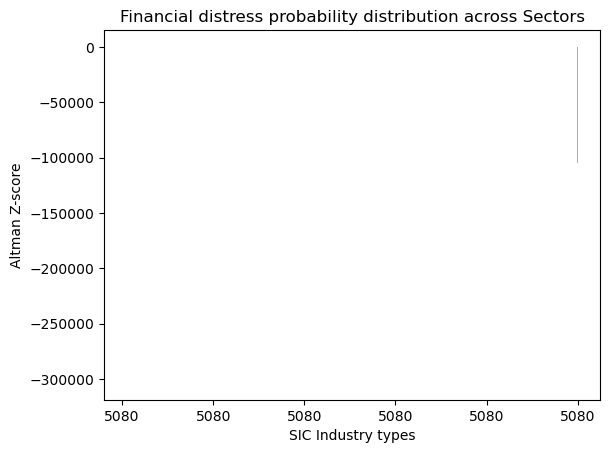

In [66]:
probability_fin_distress = df['financial distress prob']

# Create a bar chart
fig, ax = plt.subplots()
bar_chart_2 = ax.bar(sic_codes, probability_fin_distress, color='#95b8d1')

# Set chart title, labels, and rotation
ax.set_title('Financial distress probability distribution across Sectors')
ax.set_ylabel('Altman Z-score')
ax.set_xlabel('SIC Industry types')
ax.set_xticklabels(sic_codes, rotation=0)

# Display the chart
plt.show()

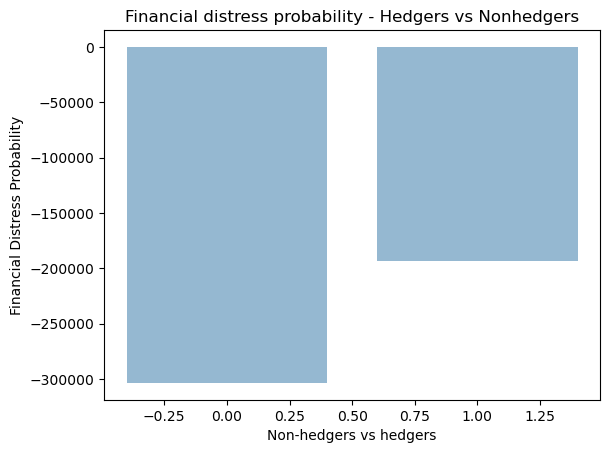

In [67]:

# Create a bar chart
fig, ax = plt.subplots()
bar_chart_hedgers = ax.bar(df['hedge group'], probability_fin_distress, color='#95b8d1')


# Set chart title, labels, and rotation
ax.set_title('Financial distress probability - Hedgers vs Nonhedgers')
ax.set_ylabel('Financial Distress Probability')
ax.set_xlabel('Non-hedgers vs hedgers')
#WHY DOESN'T IT TAKE 0 AND 1 ONLY WHY IS THERE A SCALE BELOW? THESE ARE DUMMIES!
# Display the chart
plt.show()

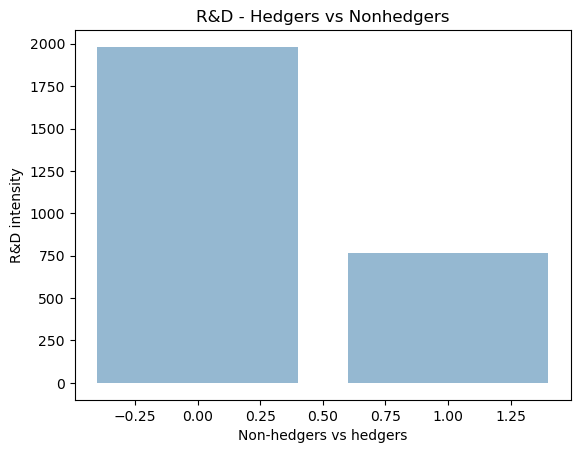

In [76]:
# Create a bar chart
fig, ax = plt.subplots()
bar_chart_hedgers_RD = ax.bar(df['hedge group'], rd_investment, color='#95b8d1')


# Set chart title, labels, and rotation
ax.set_title('R&D - Hedgers vs Nonhedgers')
ax.set_ylabel('R&D intensity')
ax.set_xlabel('Non-hedgers vs hedgers')
#WHY DOESN'T IT TAKE 0 AND 1 ONLY WHY IS THERE A SCALE BELOW? THESE ARE DUMMIES!
# Display the chart
#THIS MUST BE SIGNIFICANT! SO WHY IS THE SCATHER PLOT NOT LOOKING NICE? ALSO THE RESULTS MUST BE SIGNIFICANCE BASED ON THIS GRAPH
plt.show()

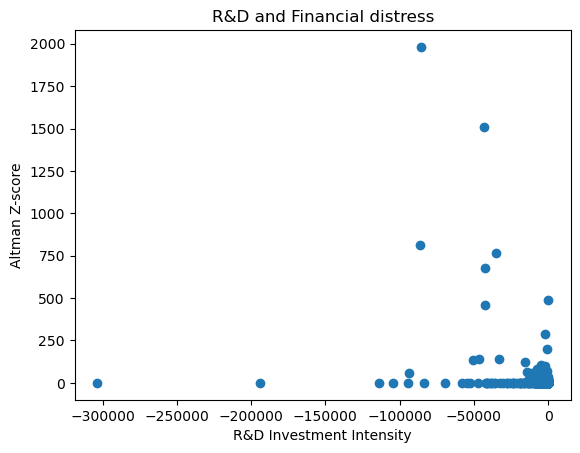

In [77]:
plt.scatter(probability_fin_distress, rd_investment)
plt.title('R&D and Financial distress')
plt.xlabel('R&D Investment Intensity')
plt.ylabel('Altman Z-score')
plt.show()
#DOES NOT LOOK LINEAR
#also there must be postiive values too? is it possible to get 0 in the middle and see the movement more closely? 

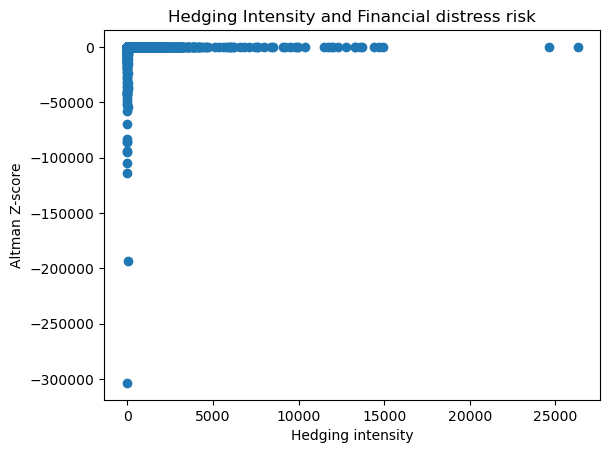

In [69]:
hedging_intensity = df['hedging intensity']
plt.scatter(hedging_intensity,probability_fin_distress)
plt.title('Hedging Intensity and Financial distress risk')
plt.xlabel('Hedging intensity')
plt.ylabel('Altman Z-score')
plt.show()

In [70]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
import statsmodels as stm 
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white
import seaborn as sns
import scipy.stats as stats

In [71]:
#SUMMARY STATISTICS 1
# I need to lag all controls one year back because of the decision 
df.groupby('hedge group')['financial distress prob'].describe(),2


(               count        mean          std       min       25%       50%  \
 hedge group                                                                   
 0            18371.0         NaN          NaN      -inf -3.295586  0.065423   
 1             9444.0 -106.585156  2725.649845 -193796.7 -0.044072  1.071605   
 
                   75%        max  
 hedge group                       
 0            1.704796        inf  
 1            1.931559  23.861896  ,
 2)

In [72]:
#INDEPENDENT T-TEST 1 LOOKING FOR STATISTICAL SIGNIFICANCE
group_1 = df[df['hedge group']==1]
group_2 = df[df['hedge group']==0]
ttest_ind(group_1['financial distress prob'], group_2['financial distress prob'])
#THIS TEST RESULT SHOULD BE SIGNIFICANT = THE HEDGERS SHOULD HAVE LESS FINANCIAL DISTRESS THAN NONHEDGERS
#ttest1_paired = ttest_rel(hedger['financial distress prob'],nonhedger['financial distress prob'])

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\numpy\core\_methods.py:211: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Ttest_indResult(statistic=nan, pvalue=nan)

In [73]:
#SUMMARY STATISTICS 2
df.groupby('hedge group')['rd intensity'].describe(),2


(               count     mean       std       min  25%       50%       75%  \
 hedge group                                                                  
 0            18371.0      inf       NaN -0.094183  0.0  0.001160  0.113273   
 1             9444.0  0.23821  8.497854 -0.506024  0.0  0.002619  0.040606   
 
                max  
 hedge group         
 0              inf  
 1            767.0  ,
 2)

In [74]:
#INDEPENDENT T-TEST 2 
ttest_ind(group_1['rd intensity'], group_2['rd intensity'])

c:\Users\Betty Reinhardova\anaconda3\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Ttest_indResult(statistic=nan, pvalue=nan)

In [80]:
#HAUSMAN TEST
from linearmodels.iv import IV2SLS
from linearmodels.panel import compare
from linearmodels import PanelOLS 

random_effect_model_1 = PanelOLS.from_formula('financial distress prob ~ hedging intensity', df)
random_effect_model_1_results = random_effect_model_1.fit()

fixed_effect_model_1 = PanelOLS.from_formula('financial distress prob ~ hedging intensity + sic', df)
fixed_effect_model_1_results = fixed_effect_model_1.fit()

hausman_test_1 = compare({'Random Effects': random_effect_model_1_results, 'Fixed Effects': fixed_effect_model_1_results})
print(hausman_test_1)


ModuleNotFoundError: No module named 'linearmodels'

In [ ]:
random_effect_model_2 = PanelOLS.from_formula('rd intensity ~ financial distress prob', df)
random_effect_model_2_results = random_effect_model_2.fit()

fixed_effect_model_2 = PanelOLS.from_formula('rd intensity ~ financial distress prob + sic', df)
fixed_effect_model_2_results = fixed_effect_model_2.fit()

hausman_test_2 = compare({'Random Effects': random_effect_model_2_results, 'Fixed Effects': fixed_effect_model_2_results})
print(hausman_test_2)

In [ ]:
random_effect_model_3 = PanelOLS.from_formula('rd intensity ~ hedging intensity', df)
random_effect_model_3_results = random_effect_model_3.fit()

fixed_effect_model_3 = PanelOLS.from_formula('rd intensity ~ hedging intensity + sic', df)
fixed_effect_model_3_results = fixed_effect_model_3.fit()

hausman_test_3 = compare({'Random Effects': random_effect_model_3_results, 'Fixed Effects': fixed_effect_model_3_results})
print(hausman_test_3)

In [ ]:
#IF HAUSMAN IS STATISTICALLY SIGNIFICANT P > 0.05 SUGGESTS THAT THERE IS A SIGNIFICANT
#DIFFERENCE BETWEEEN THE RANDOM EFFECTS AND FIXED EFFECTS MODELS =REJECT H0
#THAT THE RANDOME EFFECTS MODEL IS CONSISTENT AND EFFICIENT = CHOOSE FIXED EFFECTS MODEL 
#BECAUSE IT ACCOUNTS FOR UNOBSERVED VARIABLES 
#IF P < 0.05 = THERE IS NO SIGNIFICANT DIFFERENCE BETWEEN RANDOME AND FIXED MODELS 
#CHOOSE RANDOM EFFECTS MODEL 
#Random effects model is more appropriate if you assume that the unobserved 
#heterogeneity is not correlated with the independent variables, while fixed 
#effects model is more appropriate if you want to control for individual-specific
# effects

In [ ]:
#OLS = pooled 1
sns.scatterplot(x=df['hedging intensity'], y=df['financial distress prob'], hue=df['sic'])
plt.show()
#not workign cause of string -> is it becasue I do have Nan values? 

x_var_ols1 =
y_var_ols2 =
pooled_ols_1 = sm.OLS(endog=y_var_ols2,exog=x_var_ols1)
pooled_ols_1_results = pooled_ols_1.fit()
print(pooled_ols_1_results.summary()) 

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 825.202x583.564 with 1 Axes>

In [ ]:
#OLS = pooled 2 

In [ ]:
#Robustness test 